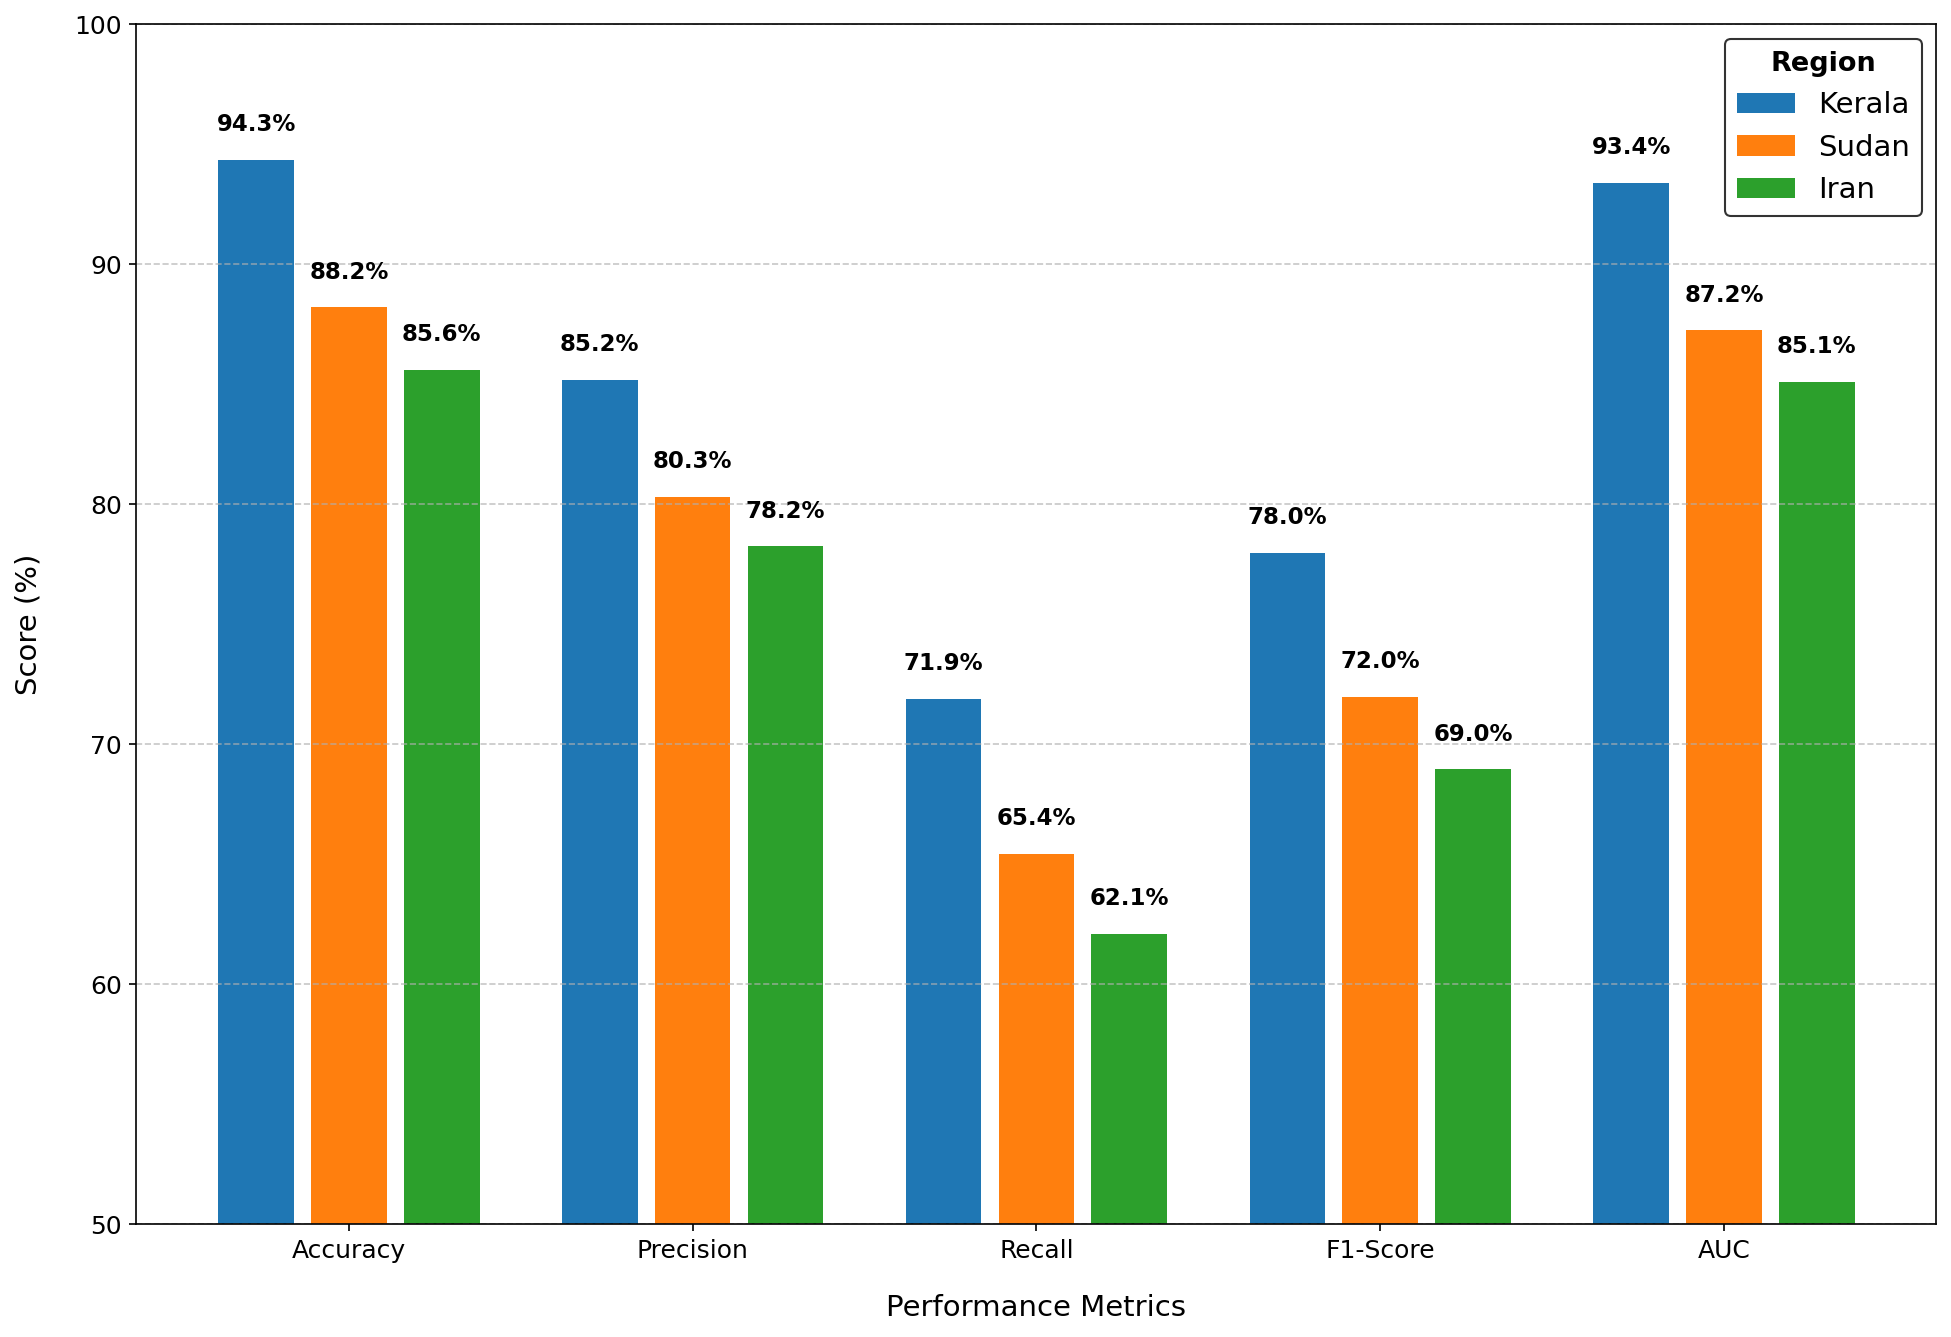

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from bs4 import BeautifulSoup

# HTML table content
html_table = """
<table><thead><tr><td colspan="7"><b>Table 12: Cross-Regional Performance of the Ensemble Model (95% Confidence Intervals)</b></td></tr><tr><td><b>Dataset</b></td><td><b>Accuracy</b></td><td><b>Precision</b></td><td><b>Recall</b></td><td><b>F1-Score</b></td><td><b>AUC</b></td></tr></thead><tbody><tr><td>Kerala [28]</td><td>94.34 [93.21, 95.47]</td><td>0.8519 [0.8321, 0.8717]</td><td>0.7188 [0.6921, 0.7455]</td><td>0.7797 [0.7612, 0.7982]</td><td>0.9338 [0.9211, 0.9465]</td></tr><tr><td>Sudan [17]</td><td>88.20 [86.50, 89.90]</td><td>0.8031 [0.7812, 0.8250]</td><td>0.6543 [0.6312, 0.6774]</td><td>0.7198 [0.7011, 0.7385]</td><td>0.8725 [0.8567, 0.8883]</td></tr><tr><td>Iran [41]</td><td>85.60 [83.70, 87.50]</td><td>0.7824 [0.7601, 0.8047]</td><td>0.6210 [0.5978, 0.6442]</td><td>0.6895 [0.6702, 0.7088]</td><td>0.8510 [0.8341, 0.8679]</td></tr></tbody></table>
"""

# Parse HTML table
soup = BeautifulSoup(html_table, 'html.parser')
rows = soup.find_all('tr')

# Extract headers and data
headers = [td.get_text().strip() for td in rows[1].find_all('td')]
data = []
for row in rows[2:5]:
    cols = row.find_all('td')
    data.append([col.get_text().strip() for col in cols])

# Create DataFrame
df = pd.DataFrame(data, columns=headers)
df['Dataset'] = df['Dataset'].str.replace(r'\s*\[\d+\]', '', regex=True)  # Remove references

# Function to extract values and confidence intervals
def extract_values(s):
    match = re.search(r'([\d.]+)\s*\[([\d.]+),\s*([\d.]+)\]', s)
    if match:
        return float(match.group(1)), float(match.group(2)), float(match.group(3))
    return float(s), None, None

# Process metrics and convert to percentages
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
cohorts = df['Dataset'].tolist()
data_dict = {metric: {} for metric in metrics}

for i, cohort in enumerate(cohorts):
    for metric in metrics:
        value, lower, upper = extract_values(df.loc[df['Dataset'] == cohort, metric].iloc[0])

        # Convert to percentage for non-accuracy metrics
        if metric != 'Accuracy':
            value *= 100
            lower *= 100
            upper *= 100

        data_dict[metric][cohort] = (value, lower, upper)

# Plot configuration - HIGH RESOLUTION SETTINGS
plt.figure(figsize=(16, 10), dpi=150)  # Increased size and resolution
bar_width = 0.22
spacing = 0.05
x = np.arange(len(metrics))  # Metric positions
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Distinct colors for cohorts

# Create bars with error bars
for i, cohort in enumerate(cohorts):
    values = [data_dict[metric][cohort][0] for metric in metrics]
    lower_errors = [data_dict[metric][cohort][0] - data_dict[metric][cohort][1] for metric in metrics]
    upper_errors = [data_dict[metric][cohort][2] - data_dict[metric][cohort][0] for metric in metrics]
    yerr = [lower_errors, upper_errors]

    # Calculate positions for this cohort
    positions = x + i * (bar_width + spacing) - (len(cohorts)-1)/2 * (bar_width + spacing)

    plt.bar(positions, values, width=bar_width,
            color=colors[i], label=cohort)
            # error_kw={'elinewidth': 1.5, 'capthick': 1.5})  # Thicker error bars

# Add labels and title with larger fonts
plt.xlabel('Performance Metrics', fontsize=14, labelpad=15)
plt.ylabel('Score (%)', fontsize=14, labelpad=15)
# plt.title('Cross-Regional Performance of Ensemble Model\n(95% Confidence Intervals)',
#           fontsize=16, pad=25, fontweight='bold')
plt.xticks(x, metrics, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(50, 100)  # Consistent scale for comparison
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars with larger font
for i, cohort in enumerate(cohorts):
    positions = x + i * (bar_width + spacing) - (len(cohorts)-1)/2 * (bar_width + spacing)
    for j, metric in enumerate(metrics):
        value = data_dict[metric][cohort][0]
        plt.text(positions[j], value + 1, f'{value:.1f}%',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')  # Increased font size

# Enhanced legend - larger and clearer
legend = plt.legend(title='Region', frameon=True, loc='upper right',
                   fontsize=14, title_fontsize=13,  # Larger font sizes
                   edgecolor='black',  # Border for clarity
                   facecolor='white')  # Background color
legend.get_title().set_fontweight('bold')  # Bold title

# Adjust layout and add padding
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.2, right=0.95)

# Save as high-resolution image (optional)
# plt.savefig('ensemble_performance.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()